[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We covered breakpoints as a general way to stop the graph at specific steps, which enables use-cases like `Approval`

We also showed how to edit graph state, and introduce human feedback. 

## Goals

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

In [14]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_mistralai langgraph_sdk

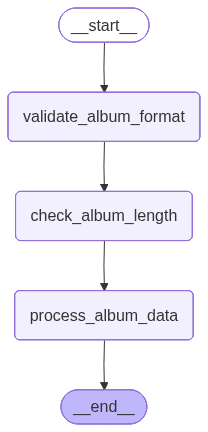

In [15]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    album_name: str

def validate_album_format(state: State) -> State:
    print("---Step 1: Validating Album Name Format---")
    return state

def check_album_length(state: State) -> State:
    # Dynamic interrupt if album name is too long (John Mayer's albums are typically short titles)
    if len(state['album_name']) > 20:
        raise NodeInterrupt(f"Album name too long for John Mayer's style: '{state['album_name']}' ({len(state['album_name'])} chars). His albums typically have concise titles!")
    
    print("---Step 2: Album Name Length Check Passed---")
    return state

def process_album_data(state: State) -> State:
    print(f"---Step 3: Processing Album '{state['album_name']}'---")
    return state

builder = StateGraph(State)
builder.add_node("validate_album_format", validate_album_format)
builder.add_node("check_album_length", check_album_length)
builder.add_node("process_album_data", process_album_data)
builder.add_edge(START, "validate_album_format")
builder.add_edge("validate_album_format", "check_album_length")
builder.add_edge("check_album_length", "process_album_data")
builder.add_edge("process_album_data", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with a very long album name that exceeds John Mayer's typical naming style (his actual albums like "Continuum", "Heavier Things", "Room for Squares" are all under 20 characters).

In [16]:
initial_input = {"album_name": "The Complete John Mayer Guitar Collection"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'album_name': 'The Complete John Mayer Guitar Collection'}
---Step 1: Validating Album Name Format---
{'album_name': 'The Complete John Mayer Guitar Collection'}
{'__interrupt__': (Interrupt(value="Album name too long for John Mayer's style: 'The Complete John Mayer Guitar Collection' (41 chars). His albums typically have concise titles!", id='placeholder-id'),)}


/tmp/ipykernel_48099/620144565.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Album name too long for John Mayer's style: '{state['album_name']}' ({len(state['album_name'])} chars). His albums typically have concise titles!")


If we inspect the graph state at this point, we see the node set to execute next (`check_album_length`), which was interrupted due to the album name being too long.


In [17]:
state = graph.get_state(thread_config)
print(state.next)

('check_album_length',)


We can see that the `Interrupt` is logged to state.

In [18]:
print(state.tasks)

(PregelTask(id='f35538f2-e104-4933-14b8-0009693e9f63', name='check_album_length', path=('__pregel_pull', 'check_album_length'), error=None, interrupts=(Interrupt(value="Album name too long for John Mayer's style: 'The Complete John Mayer Guitar Collection' (41 chars). His albums typically have concise titles!", id='placeholder-id'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [19]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'album_name': 'The Complete John Mayer Guitar Collection'}
{'__interrupt__': (Interrupt(value="Album name too long for John Mayer's style: 'The Complete John Mayer Guitar Collection' (41 chars). His albums typically have concise titles!", id='placeholder-id'),)}


/tmp/ipykernel_48099/620144565.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Album name too long for John Mayer's style: '{state['album_name']}' ({len(state['album_name'])} chars). His albums typically have concise titles!")


In [20]:
state = graph.get_state(thread_config)
print(state.next)

('check_album_length',)


Now, we can update state.

In [21]:
graph.update_state(
    thread_config,
    {"album_name": "Continuum"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3509-ed02-6088-8002-b13381d141f6'}}

In [22]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'album_name': 'Continuum'}
---Step 2: Album Name Length Check Passed---
{'album_name': 'Continuum'}
---Step 3: Processing Album 'Continuum'---
{'album_name': 'Continuum'}


### Usage with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

In [23]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

We connect to it via the SDK.

In [24]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [25]:
thread = await client.threads.create()
input_dict = {"album_name": "The John Mayer Trio Live in Concert"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2677-1329-72a8-b3cb-da09cc2efef6', 'attempt': 1}



Receiving new event of type: error...
{'error': 'KeyError', 'message': "'input'"}





In [26]:
current_state = await client.threads.get_state(thread['thread_id'])

In [27]:
current_state['next']

['step_2']

In [28]:
await client.threads.update_state(thread['thread_id'], {"album_name": "Battle Studies"})

{'checkpoint': {'thread_id': 'bc8b93dc-5002-4e7e-a716-86bdb9e502c1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3509-f64c-6449-8002-53026c1b5e2b'},
 'configurable': {'thread_id': 'bc8b93dc-5002-4e7e-a716-86bdb9e502c1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3509-f64c-6449-8002-53026c1b5e2b'},
 'checkpoint_id': '1f0b3509-f64c-6449-8002-53026c1b5e2b'}

In [29]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2677-16d8-75bc-ae93-4837d8416e36', 'attempt': 1}



Receiving new event of type: values...
{}



Receiving new event of type: error...
{'error': 'KeyError', 'message': "'input'"}





In [30]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {},
 'next': ['step_2'],
 'tasks': [{'id': '3c348539-48b7-dc20-d5f0-13f55a341ffb',
   'name': 'step_2',
   'path': ['__pregel_pull', 'step_2'],
   'error': "KeyError('input')",
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'dynamic_breakpoints',
  'thread_id': 'bc8b93dc-5002-4e7e-a716-86bdb9e502c1',
  'source': 'update',
  'step': 2,
  'parents': {}},
 'created_at': '2025-10-27T16:18:50.142176+00:00',
 'checkpoint': {'checkpoint_id': '1f0b3509-f64c-6449-8002-53026c1b5e2b',
  'thread_id': 'bc8b93dc-5002-4e7e-a716-86bdb9e502c1',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f0b3509-f559-6134-8001-0919cea07460',
  'thread_id': 'bc8b93dc-5002-4e7e-a716-86bdb9e502c1',
  'checkpoint_ns': ''},
 'interrupts': [],
 'checkpoint_id': '1f0b3509-f64c-6449-8002-53026c1b5e2b',
 'parent_checkpoint_id': '1f0b3509-f559-6134-8001-0919cea07460'}